# Variational Autoencoder (VAE)

In [1]:
import numpy as np
import os
from cv2 import imread, resize
import pandas as pd

def fetch_lfw_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      raw_images_name = "lfw",
                      use_raw=False,
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):#sad smile

    #download if not exists
    if (not use_raw) and not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if use_raw and not os.path.exists(raw_images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(raw_images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s"%attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    df_attrs.imagenum = df_attrs.imagenum.astype(np.int64)


    #read photos
    dirname = raw_images_name if use_raw else images_name
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(dirname):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos = df['photo_path'].apply(imread)\
                                 .apply(lambda img: img[dy:-dy,dx:-dx])\
                                 .apply(lambda img: resize(img, (dimx, dimy)))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos,all_attrs

Useful links:
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset [http://vis-www.cs.umass.edu/lfw/](http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [2]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.initializers as I
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# The following code fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_lfw_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [4]:
print(attrs.shape)
print(data.shape)
attrs.head()

(13143, 73)
(13143, 45, 45, 3)


,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152


In [313]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [314]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [315]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

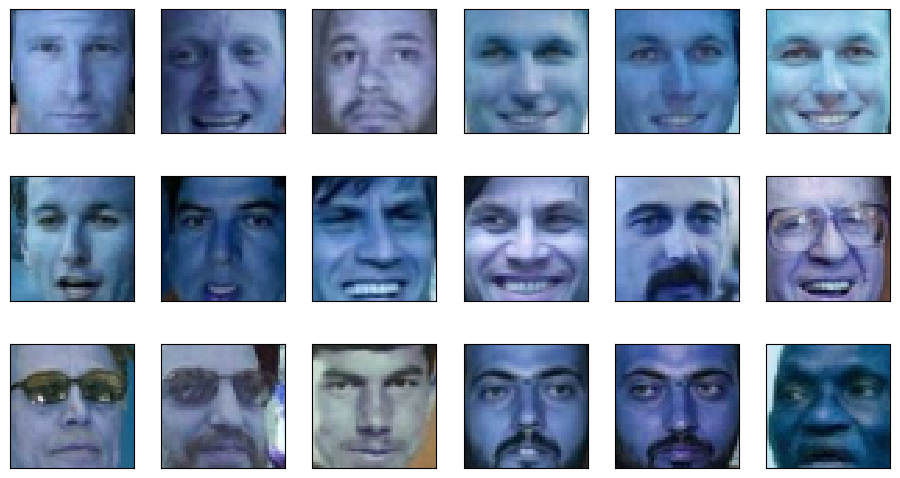

In [316]:
plot_gallery(X_train, image_h, image_w)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:


<img src="/content/Autoencoder_structure.jpg">

In [ ]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# You can define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

# However, you can just have 1 fc layer in each network without any activation,
# and it will also show some results

vanila_encoder = tf.keras.Sequential()
vanila_encoder.add(L.Dense(4*dimZ, activation='relu', kernel_initializer=I.GlorotUniform()))
vanila_encoder.add(L.Dense(dimZ, kernel_initializer=I.GlorotUniform()))
vanila_decoder = tf.keras.Sequential()
vanila_decoder.add(L.Dense(4*dimZ, activation='relu', kernel_initializer=I.GlorotUniform()))
vanila_decoder.add(L.Dense(X_train.shape[1], activation='sigmoid', kernel_initializer=I.GlorotUniform()))

model = tf.keras.Sequential()
model.add(vanila_encoder)
model.add(vanila_decoder)

In [288]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, rate):
        super(DisplayCallback, self).__init__()
        self.model = model
        self.rate = rate

    def on_epoch_end(self, epoch, logs=None):
        model = self.model
        if epoch % self.rate == 0:
            idx = np.random.choice(X_train.shape[0])
            plt.subplot(221)
            plt.imshow(X_train[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(222)
            plt.imshow(tf.reshape(
                model(X_train[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            idx = np.random.choice(X_val.shape[0])
            plt.subplot(223)
            plt.imshow(X_val[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(224)
            plt.imshow(tf.reshape(
                model(X_val[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            plt.show()

In [ ]:
# Create MSE loss function
loss = tf.keras.losses.mean_squared_error
# Use Adam optimizer
opt = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=opt)
callback = DisplayCallback(model, 10)

In [ ]:
model.build(input_shape=X_train.shape)

Epoch 1/30
309/313 [============================>.] - ETA: 0s - loss: 0.0172

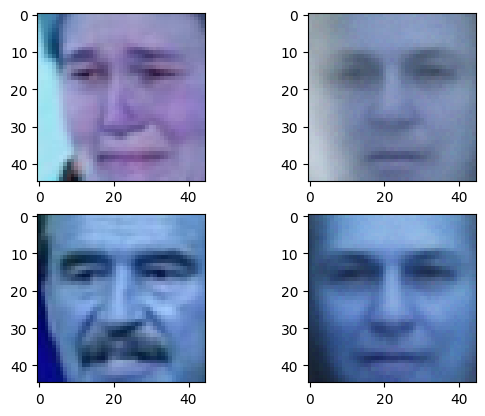

313/313 [==============================] - 4s 7ms/step - loss: 0.0171 - val_loss: 0.0135
Epoch 2/30
313/313 [==============================] - 1s 4ms/step - loss: 0.0111 - val_loss: 0.0098
Epoch 3/30
313/313 [==============================] - 1s 4ms/step - loss: 0.0085 - val_loss: 0.0072
Epoch 4/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 5/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 6/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 7/30
313/313 [==============================] - 1s 4ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 8/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 9/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 10/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 11/3

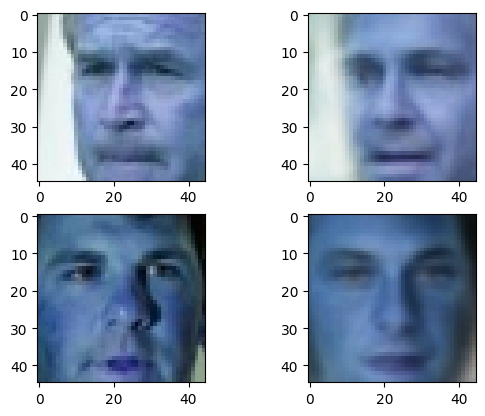

313/313 [==============================] - 2s 6ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 12/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 13/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0046 - val_loss: 0.0049
Epoch 14/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 15/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 16/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 17/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 18/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 19/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 20/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0044 - val_loss: 0.0047
Ep

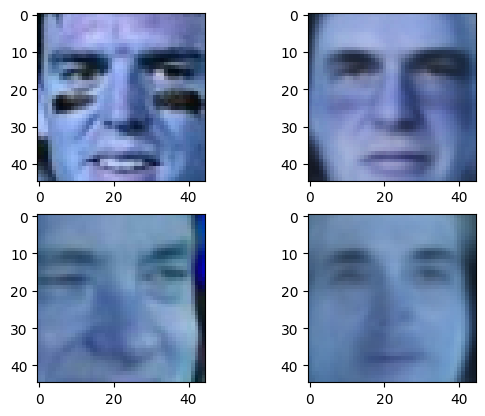

313/313 [==============================] - 2s 7ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 22/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 23/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 24/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 25/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 26/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 27/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0042 - val_loss: 0.0048
Epoch 28/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 29/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0043 - val_loss: 0.0050
Epoch 30/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0042 - val_loss: 0.0046


In [ ]:
# Train your autoencoder
# Add validation data
# Visualize progress in reconstruction and loss decay
history = model.fit(
    X_train, X_train,
    epochs=30,
    validation_data = (X_val, X_val),
    callbacks=[callback]
)

Plot your loss values (also metrics, if you used them) for train and validation data

KeyError: ignored

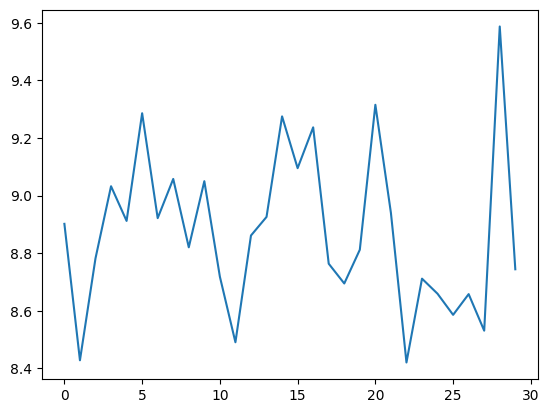

In [101]:
plt.plot(np.arange(30), history.history['loss'])
plt.plot(np.arange(30), history.history['val_loss'])
plt.show()

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

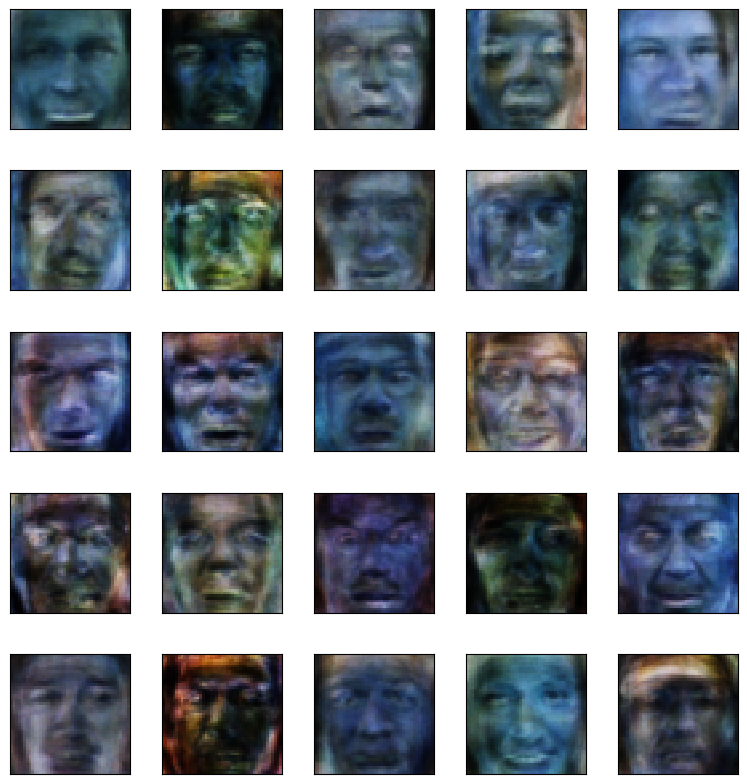

In [ ]:
z = np.random.randn(25, dimZ)
output = vanila_decoder(z).numpy()
plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

# Homework: Variational Autoencoder

In [291]:
X_train[0].shape

(6075,)

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler**, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [325]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 50

# define the network
# you can start from pytorch example https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST
input_shape = X_train.shape[1]
input = L.Input(input_shape,name = 'encoder_input',)
x = L.Dense(dimZ)(input)
x = L.LeakyReLU(alpha=0.1)(x)
x = L.Dense(dimZ, name = 'third_layer')(x)
x = L.LeakyReLU(alpha = 0.1)(x)
mean = L.Dense(dimZ,name='mean')(x)
log_var = L.Dense(dimZ,name='var')(x)


def reparam(params):
  mean,log_var = params
  sample =  tf.keras.backend.random_normal(shape = tf.shape(mean))
  return tf.exp(log_var/2)*sample + mean

z = L.Lambda(reparam,name='encoder_out')([mean,log_var])



encoder = tf.keras.Model(input, [mean,log_var,z]) # output should be mean, variance and a sample

input_dec = L.Input(dimZ,name = 'decoder_input')
t = L.Dense(dimZ,name = 'first_dec_layer')(input_dec)
t = L.LeakyReLU(0.1)(t)
t = L.Dense(dimZ,activation = 'relu')(t)
t = L.LeakyReLU(0.1)(t)
output = L.Dense(input_shape, name = 'last_decoding_layer',activation = 'sigmoid')(t)
decoder = tf.keras.Model(input_dec, [output])

In [328]:
encoder.summary()

Model: "model_71"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 6075)]       0           []                               
                                                                                                  
 dense_27 (Dense)               (None, 50)           303800      ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu_1 (LeakyReLU)      (None, 50)           0           ['dense_27[0][0]']               
                                                                                                  
 third_layer (Dense)            (None, 50)           2550        ['leaky_re_lu_1[0][0]']          
                                                                                           

In [329]:
decoder.summary()

Model: "model_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 50)]              0         
                                                                 
 first_dec_layer (Dense)     (None, 50)                2550      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 50)                0         
                                                                 
 dense_28 (Dense)            (None, 50)                2550      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 50)                0         
                                                                 
 last_decoding_layer (Dense)  (None, 6075)             309825    
                                                                 
Total params: 314,925
Trainable params: 314,925
Non-traina

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

In [321]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    @tf.function
    def KL_divergence(self, mu, logsigma):
      # return -.5 * tf.keras.backend.mean(1 + logsigma - tf.keras.backend.square(mu)  - tf.keras.backend.exp(logsigma)   )
      return tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + logsigma - tf.square(mu) - tf.exp(logsigma)),axis = 1))


    @tf.function
    def log_likelihood(self, x, z):
      return tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=z, labels=x),axis = 1))
    def train_step(self, data):
      with tf.GradientTape() as tape:
        mean,log_var,z = self.encoder(data)
        rec = self.decoder(z)
        loss = self.KL_divergence(mean,log_var) + self.log_likelihood(data,rec)
      grads = tape.gradient(loss,self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      return {
          'loss' : loss
      }

    def call(self, inputs):
      return self.decoder(self.encoder(inputs)[2])

In [330]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
callback = DisplayCallback(vae, 2)

And train the model:

Epoch 1/100
 9/10 [==========================>...] - ETA: 0s - loss: 4045.3040

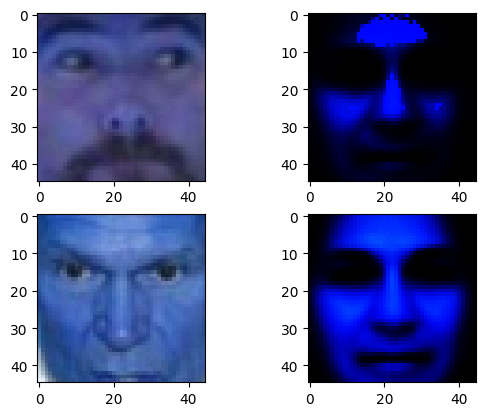

10/10 [==============================] - 1s 91ms/step - loss: 4045.1778
Epoch 2/100
10/10 [==============================] - 0s 28ms/step - loss: 4046.0020
Epoch 3/100
 9/10 [==========================>...] - ETA: 0s - loss: 4044.8223

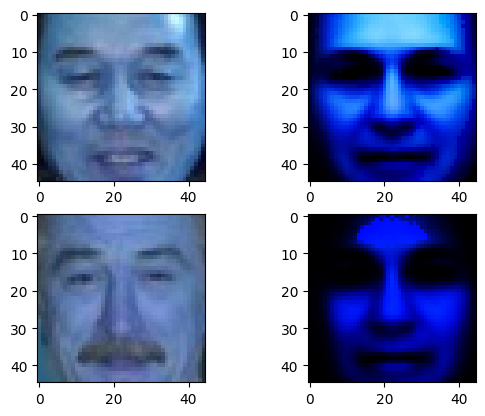

10/10 [==============================] - 1s 94ms/step - loss: 4045.3742
Epoch 4/100
10/10 [==============================] - 0s 29ms/step - loss: 4045.4008
Epoch 5/100
 9/10 [==========================>...] - ETA: 0s - loss: 4045.2632

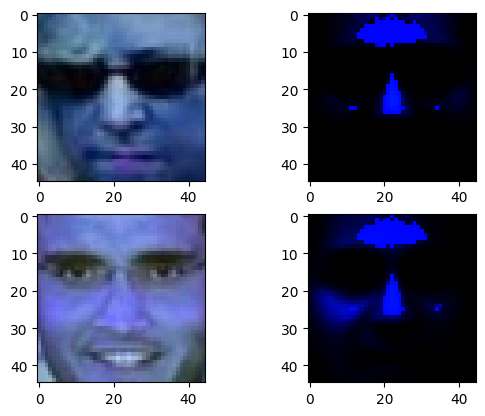

10/10 [==============================] - 1s 83ms/step - loss: 4045.0730
Epoch 6/100
10/10 [==============================] - 0s 23ms/step - loss: 4043.9581
Epoch 7/100
10/10 [==============================] - ETA: 0s - loss: 4044.4693

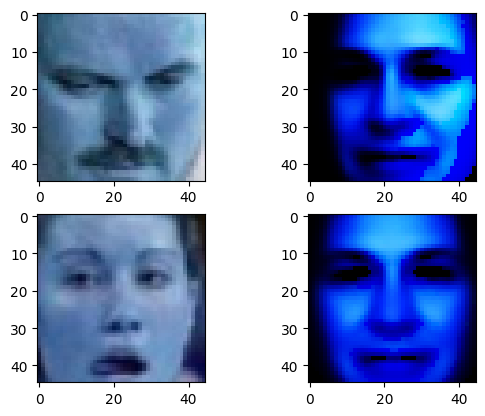

10/10 [==============================] - 1s 70ms/step - loss: 4043.9041
Epoch 8/100
10/10 [==============================] - 0s 23ms/step - loss: 4046.0330
Epoch 9/100
10/10 [==============================] - ETA: 0s - loss: 4045.4205

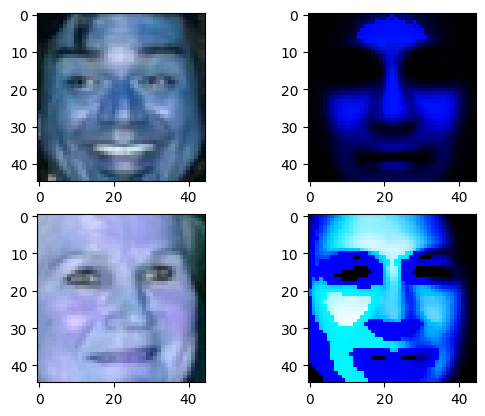

10/10 [==============================] - 1s 71ms/step - loss: 4045.9364
Epoch 10/100
10/10 [==============================] - 0s 23ms/step - loss: 4043.5688
Epoch 11/100
10/10 [==============================] - ETA: 0s - loss: 4043.6568

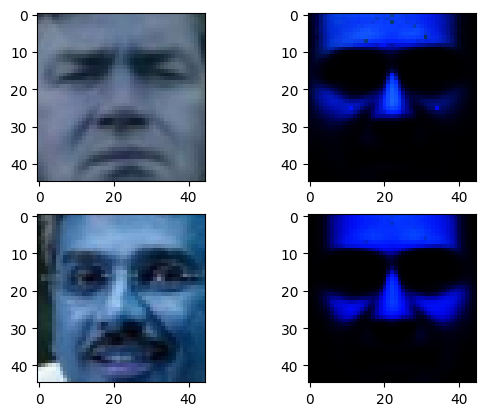

10/10 [==============================] - 1s 71ms/step - loss: 4043.9189
Epoch 12/100
10/10 [==============================] - 0s 24ms/step - loss: 4043.9290
Epoch 13/100
 8/10 [=======================>......] - ETA: 0s - loss: 4043.1490

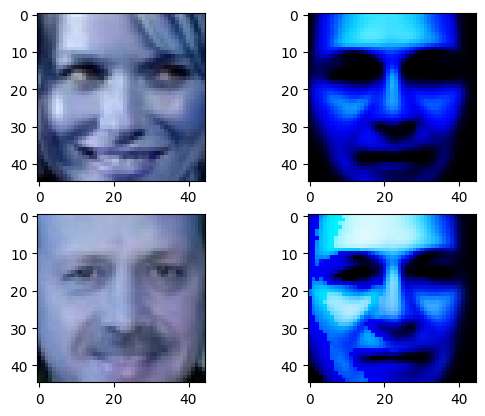

10/10 [==============================] - 1s 73ms/step - loss: 4042.3806
Epoch 14/100
10/10 [==============================] - 0s 23ms/step - loss: 4043.2655
Epoch 15/100
 9/10 [==========================>...] - ETA: 0s - loss: 4042.0594

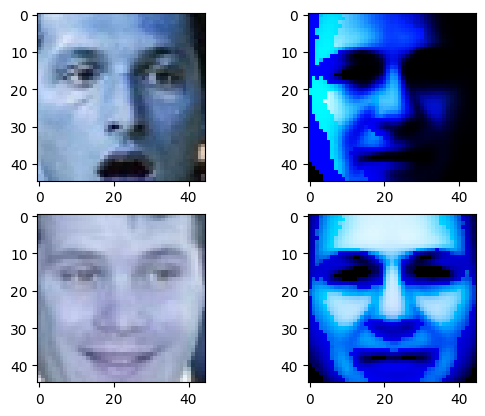

10/10 [==============================] - 1s 112ms/step - loss: 4043.6339
Epoch 16/100
10/10 [==============================] - 0s 25ms/step - loss: 4042.1432
Epoch 17/100
10/10 [==============================] - ETA: 0s - loss: 4042.4300

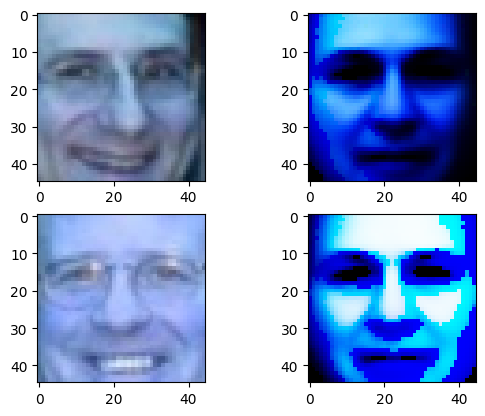

10/10 [==============================] - 1s 70ms/step - loss: 4042.7933
Epoch 18/100
10/10 [==============================] - 0s 23ms/step - loss: 4042.3879
Epoch 19/100
10/10 [==============================] - ETA: 0s - loss: 4041.4015

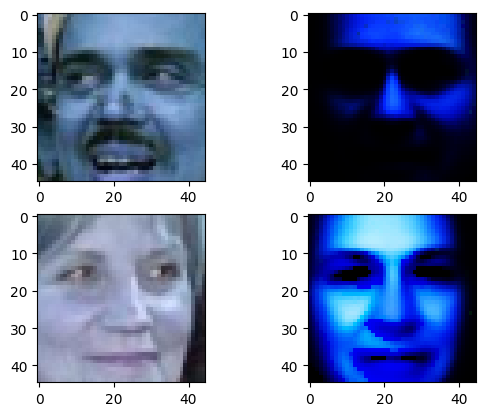

10/10 [==============================] - 1s 71ms/step - loss: 4041.6480
Epoch 20/100
10/10 [==============================] - 0s 23ms/step - loss: 4040.6400
Epoch 21/100
10/10 [==============================] - ETA: 0s - loss: 4043.0502

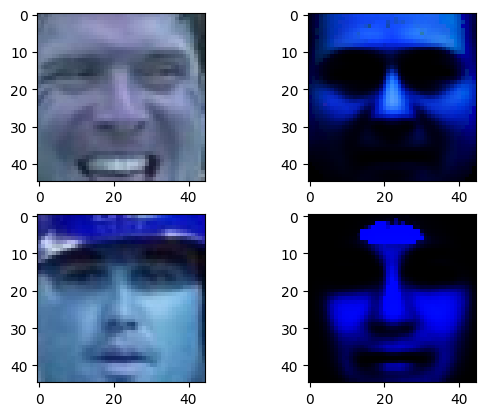

10/10 [==============================] - 1s 72ms/step - loss: 4042.4042
Epoch 22/100
10/10 [==============================] - 0s 25ms/step - loss: 4041.7734
Epoch 23/100
10/10 [==============================] - ETA: 0s - loss: 4040.2296

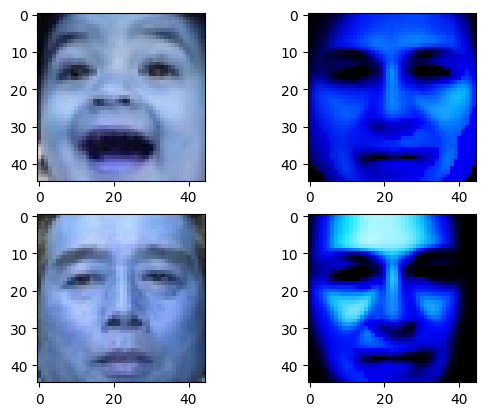

10/10 [==============================] - 1s 71ms/step - loss: 4040.2525
Epoch 24/100
10/10 [==============================] - 0s 24ms/step - loss: 4041.0519
Epoch 25/100
 9/10 [==========================>...] - ETA: 0s - loss: 4040.7705

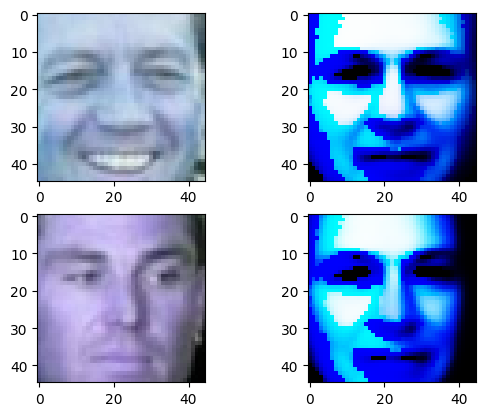

10/10 [==============================] - 1s 71ms/step - loss: 4040.3026
Epoch 26/100
10/10 [==============================] - 0s 25ms/step - loss: 4042.1736
Epoch 27/100
 9/10 [==========================>...] - ETA: 0s - loss: 4040.7253

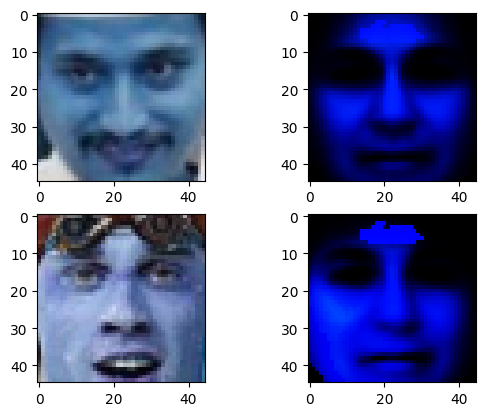

10/10 [==============================] - 1s 91ms/step - loss: 4040.7515
Epoch 28/100
10/10 [==============================] - 0s 33ms/step - loss: 4040.0040
Epoch 29/100
 9/10 [==========================>...] - ETA: 0s - loss: 4039.3884

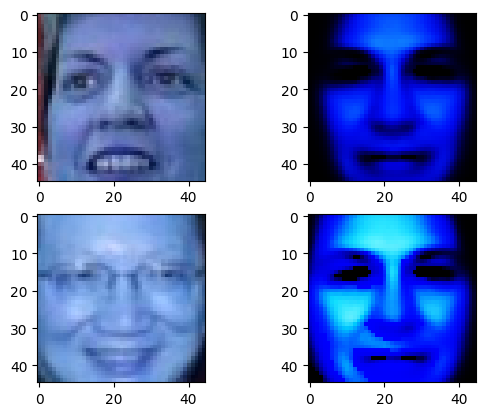

10/10 [==============================] - 1s 97ms/step - loss: 4039.4069
Epoch 30/100
10/10 [==============================] - 0s 32ms/step - loss: 4037.4474
Epoch 31/100
 9/10 [==========================>...] - ETA: 0s - loss: 4038.6437

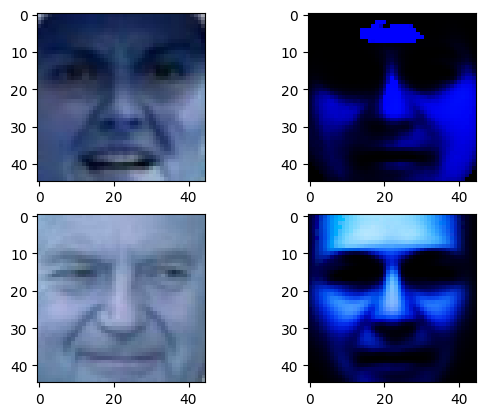

10/10 [==============================] - 1s 87ms/step - loss: 4038.8293
Epoch 32/100
10/10 [==============================] - 0s 22ms/step - loss: 4039.1429
Epoch 33/100
 8/10 [=======================>......] - ETA: 0s - loss: 4038.3407

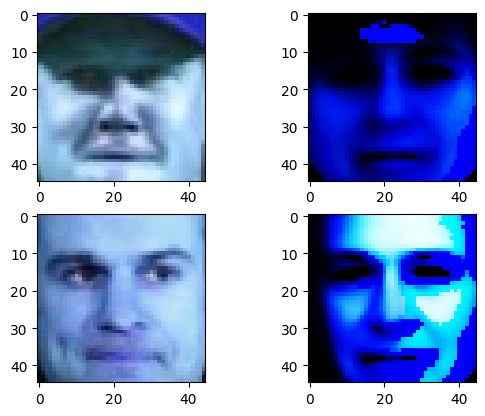

10/10 [==============================] - 1s 71ms/step - loss: 4038.4732
Epoch 34/100
10/10 [==============================] - 0s 25ms/step - loss: 4037.9606
Epoch 35/100
10/10 [==============================] - ETA: 0s - loss: 4039.3514

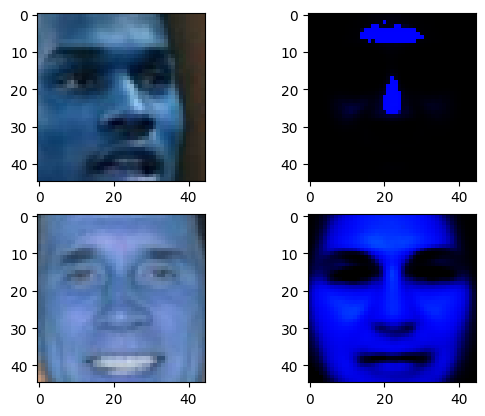

10/10 [==============================] - 1s 74ms/step - loss: 4039.9041
Epoch 36/100
10/10 [==============================] - 0s 27ms/step - loss: 4037.7063
Epoch 37/100
 9/10 [==========================>...] - ETA: 0s - loss: 4037.1873

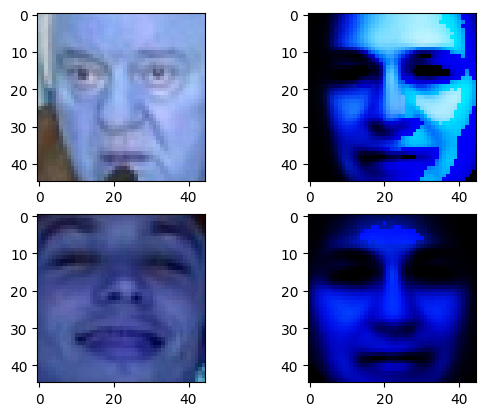

10/10 [==============================] - 1s 103ms/step - loss: 4039.2182
Epoch 38/100
10/10 [==============================] - 0s 25ms/step - loss: 4039.2847
Epoch 39/100
 9/10 [==========================>...] - ETA: 0s - loss: 4039.6470

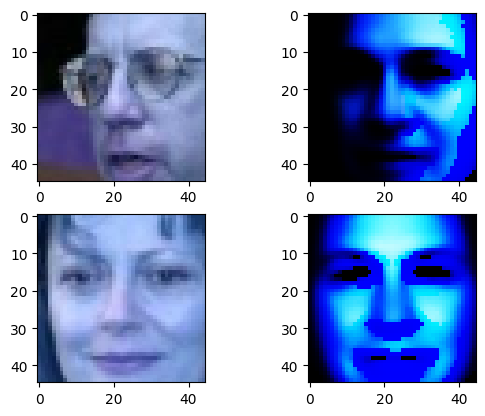

10/10 [==============================] - 1s 72ms/step - loss: 4039.1441
Epoch 40/100
10/10 [==============================] - 0s 26ms/step - loss: 4038.2103
Epoch 41/100
 8/10 [=======================>......] - ETA: 0s - loss: 4038.9080

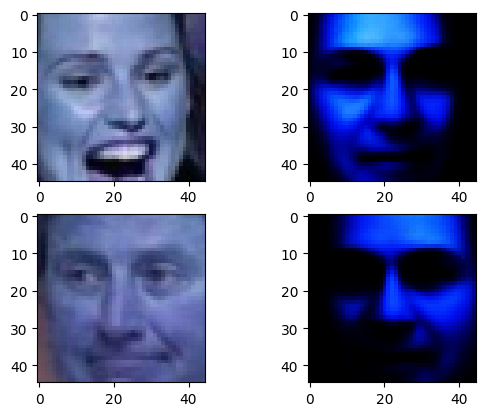

10/10 [==============================] - 1s 71ms/step - loss: 4035.8002
Epoch 42/100
10/10 [==============================] - 0s 23ms/step - loss: 4035.7162
Epoch 43/100
 8/10 [=======================>......] - ETA: 0s - loss: 4037.2701

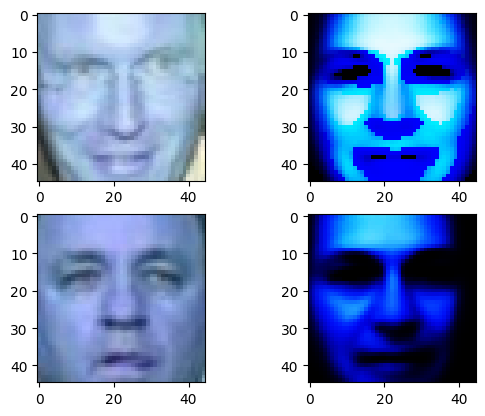

10/10 [==============================] - 1s 72ms/step - loss: 4037.7251
Epoch 44/100
10/10 [==============================] - 0s 24ms/step - loss: 4037.4771
Epoch 45/100
 8/10 [=======================>......] - ETA: 0s - loss: 4039.4060

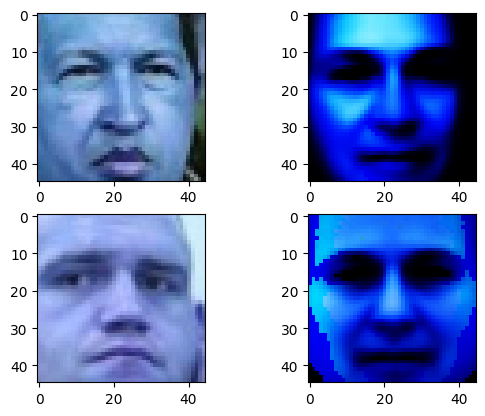

10/10 [==============================] - 1s 70ms/step - loss: 4039.6314
Epoch 46/100
10/10 [==============================] - 0s 23ms/step - loss: 4037.5091
Epoch 47/100
 8/10 [=======================>......] - ETA: 0s - loss: 4039.4904

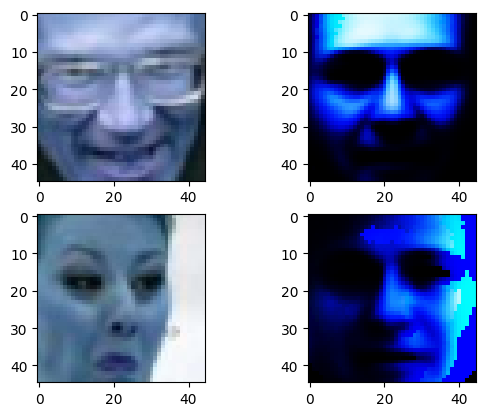

10/10 [==============================] - 1s 70ms/step - loss: 4037.1287
Epoch 48/100
10/10 [==============================] - 0s 26ms/step - loss: 4037.5427
Epoch 49/100
 8/10 [=======================>......] - ETA: 0s - loss: 4037.3900

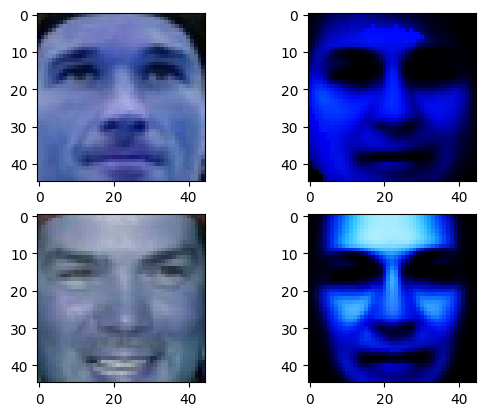

10/10 [==============================] - 1s 71ms/step - loss: 4036.9822
Epoch 50/100
10/10 [==============================] - 0s 27ms/step - loss: 4036.7575
Epoch 51/100
 9/10 [==========================>...] - ETA: 0s - loss: 4036.7320

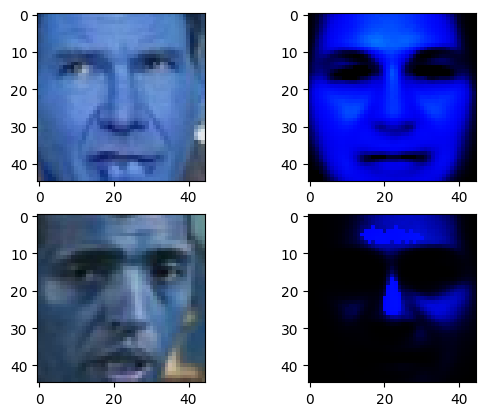

10/10 [==============================] - 1s 72ms/step - loss: 4036.1794
Epoch 52/100
10/10 [==============================] - 0s 29ms/step - loss: 4037.7505
Epoch 53/100
10/10 [==============================] - ETA: 0s - loss: 4037.3828

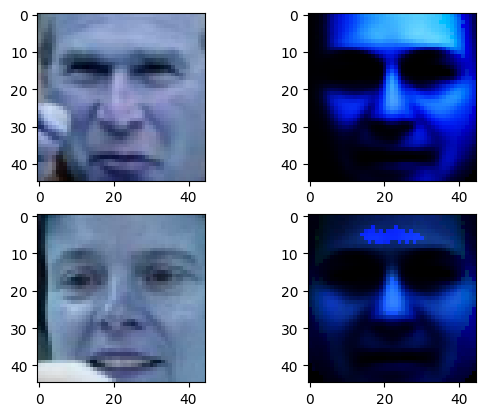

10/10 [==============================] - 1s 97ms/step - loss: 4037.2752
Epoch 54/100
10/10 [==============================] - 0s 30ms/step - loss: 4037.9220
Epoch 55/100
 9/10 [==========================>...] - ETA: 0s - loss: 4036.9151

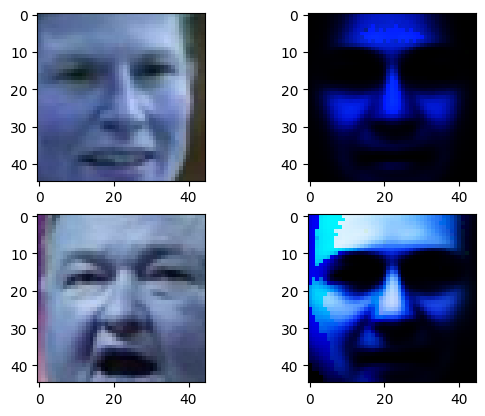

10/10 [==============================] - 1s 101ms/step - loss: 4037.5802
Epoch 56/100
10/10 [==============================] - 0s 32ms/step - loss: 4035.7108
Epoch 57/100
 9/10 [==========================>...] - ETA: 0s - loss: 4036.2888

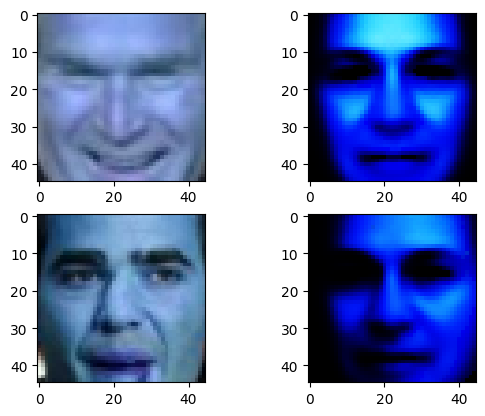

10/10 [==============================] - 1s 96ms/step - loss: 4036.2903
Epoch 58/100
10/10 [==============================] - 0s 24ms/step - loss: 4035.9860
Epoch 59/100
 8/10 [=======================>......] - ETA: 0s - loss: 4036.2850

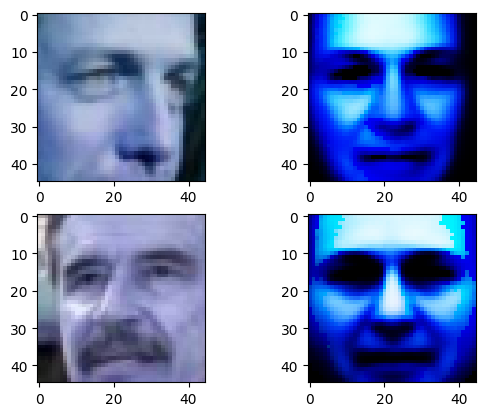

10/10 [==============================] - 1s 73ms/step - loss: 4035.7246
Epoch 60/100
10/10 [==============================] - 0s 26ms/step - loss: 4035.5296
Epoch 61/100
 9/10 [==========================>...] - ETA: 0s - loss: 4037.2213

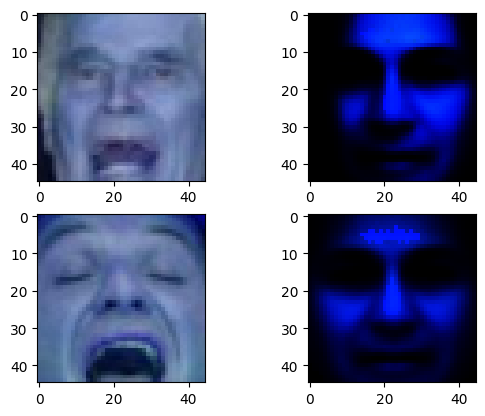

10/10 [==============================] - 1s 107ms/step - loss: 4035.8613
Epoch 62/100
10/10 [==============================] - 0s 26ms/step - loss: 4035.6048
Epoch 63/100
10/10 [==============================] - ETA: 0s - loss: 4035.5104

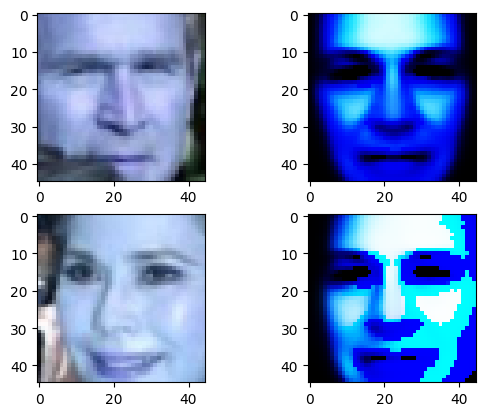

10/10 [==============================] - 1s 75ms/step - loss: 4034.9239
Epoch 64/100
10/10 [==============================] - 0s 26ms/step - loss: 4035.4941
Epoch 65/100
 8/10 [=======================>......] - ETA: 0s - loss: 4035.3195

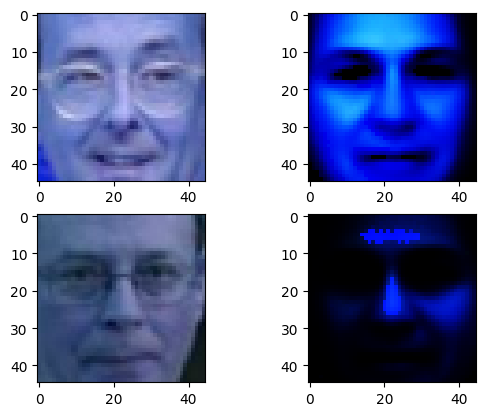

10/10 [==============================] - 1s 74ms/step - loss: 4035.7808
Epoch 66/100
10/10 [==============================] - 0s 26ms/step - loss: 4036.1369
Epoch 67/100
10/10 [==============================] - ETA: 0s - loss: 4035.7366

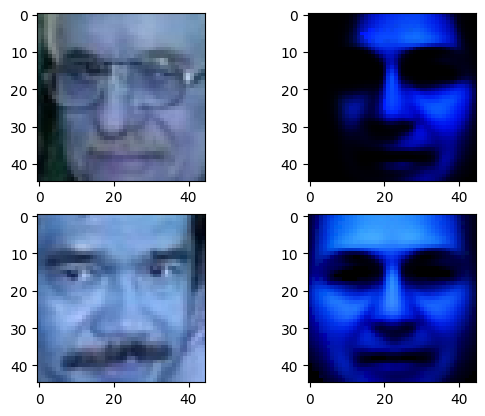

10/10 [==============================] - 1s 76ms/step - loss: 4035.9540
Epoch 68/100
10/10 [==============================] - 0s 25ms/step - loss: 4034.6577
Epoch 69/100
10/10 [==============================] - ETA: 0s - loss: 4035.3950

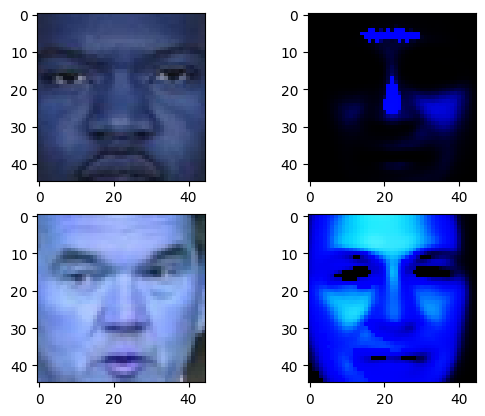

10/10 [==============================] - 1s 79ms/step - loss: 4035.9656
Epoch 70/100
10/10 [==============================] - 0s 26ms/step - loss: 4037.9120
Epoch 71/100
 8/10 [=======================>......] - ETA: 0s - loss: 4036.0889

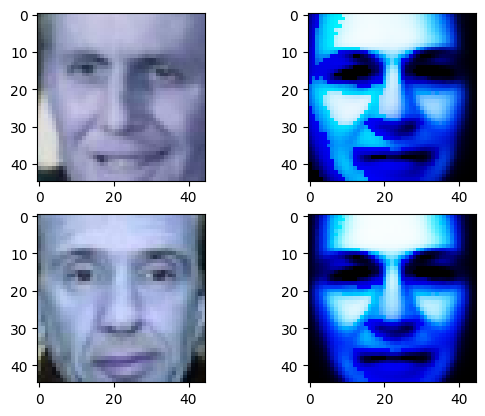

10/10 [==============================] - 1s 72ms/step - loss: 4036.3964
Epoch 72/100
10/10 [==============================] - 0s 25ms/step - loss: 4034.5591
Epoch 73/100
 9/10 [==========================>...] - ETA: 0s - loss: 4035.5494

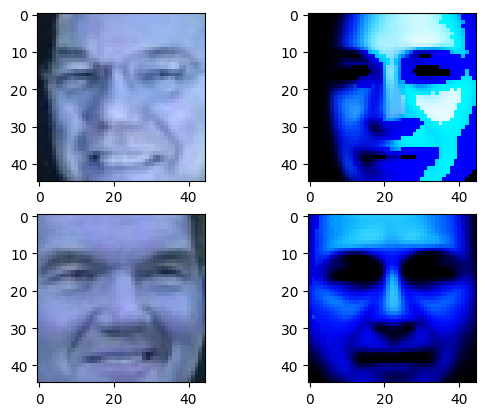

10/10 [==============================] - 1s 69ms/step - loss: 4034.5582
Epoch 74/100
10/10 [==============================] - 0s 26ms/step - loss: 4035.7042
Epoch 75/100
10/10 [==============================] - ETA: 0s - loss: 4035.5934

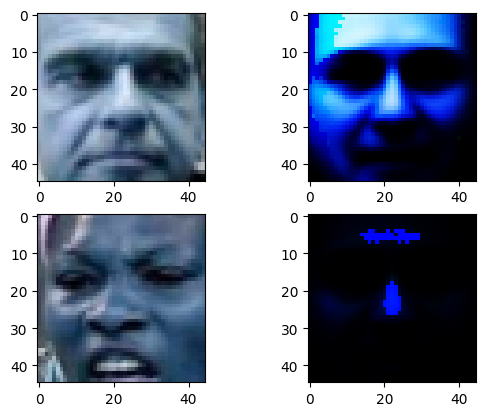

10/10 [==============================] - 1s 74ms/step - loss: 4035.8900
Epoch 76/100
10/10 [==============================] - 0s 26ms/step - loss: 4035.2510
Epoch 77/100
10/10 [==============================] - ETA: 0s - loss: 4035.3840

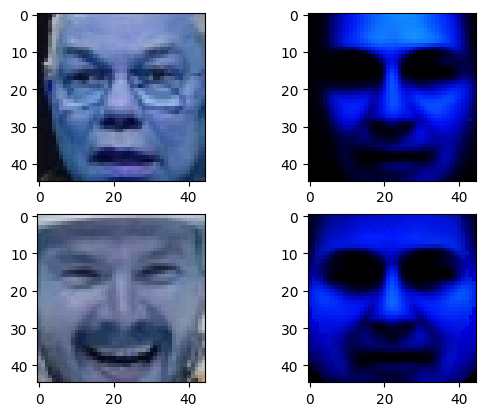

10/10 [==============================] - 1s 89ms/step - loss: 4035.6224
Epoch 78/100
10/10 [==============================] - 0s 31ms/step - loss: 4035.3558
Epoch 79/100
 9/10 [==========================>...] - ETA: 0s - loss: 4034.6675

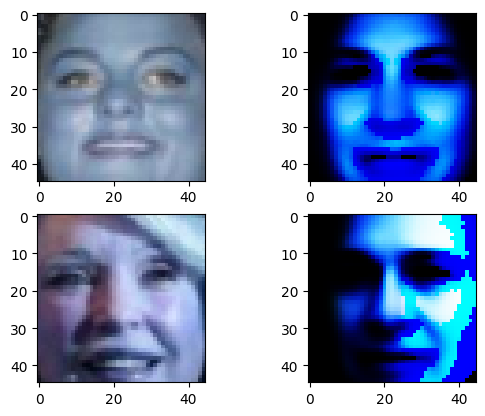

10/10 [==============================] - 1s 110ms/step - loss: 4036.0160
Epoch 80/100
10/10 [==============================] - 0s 34ms/step - loss: 4035.4681
Epoch 81/100
 9/10 [==========================>...] - ETA: 0s - loss: 4035.3162

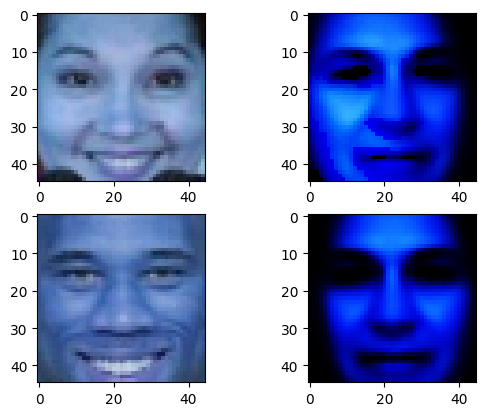

10/10 [==============================] - 1s 104ms/step - loss: 4034.7512
Epoch 82/100
10/10 [==============================] - 0s 32ms/step - loss: 4034.8019
Epoch 83/100
 9/10 [==========================>...] - ETA: 0s - loss: 4034.6652

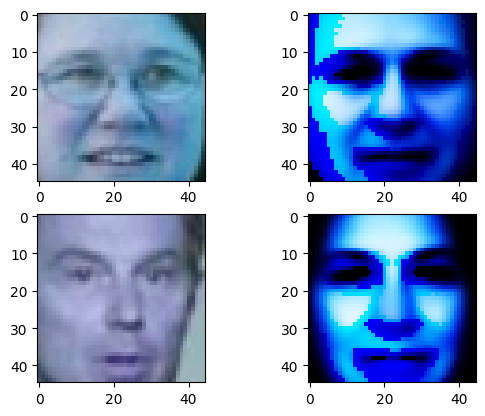

10/10 [==============================] - 1s 76ms/step - loss: 4035.4826
Epoch 84/100
10/10 [==============================] - 0s 28ms/step - loss: 4035.1716
Epoch 85/100
 9/10 [==========================>...] - ETA: 0s - loss: 4034.1561

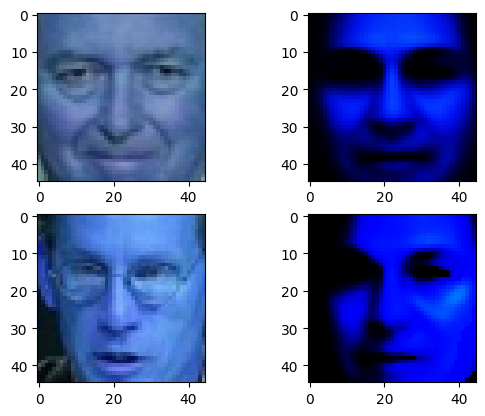

10/10 [==============================] - 1s 109ms/step - loss: 4034.7985
Epoch 86/100
10/10 [==============================] - 0s 29ms/step - loss: 4035.5392
Epoch 87/100
10/10 [==============================] - ETA: 0s - loss: 4034.2992

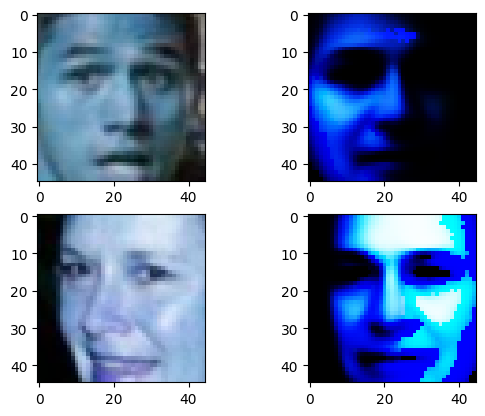

10/10 [==============================] - 1s 76ms/step - loss: 4033.9236
Epoch 88/100
10/10 [==============================] - 0s 28ms/step - loss: 4034.3540
Epoch 89/100
 9/10 [==========================>...] - ETA: 0s - loss: 4034.1019

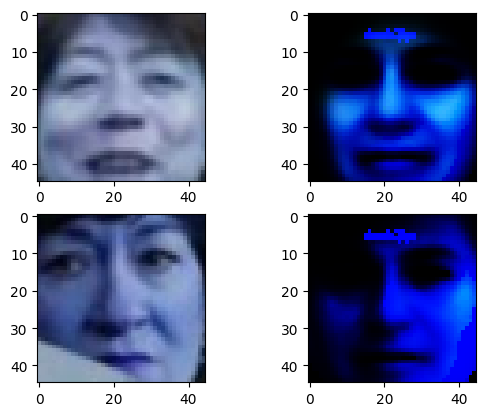

10/10 [==============================] - 1s 76ms/step - loss: 4034.2833
Epoch 90/100
10/10 [==============================] - 0s 28ms/step - loss: 4034.2487
Epoch 91/100
 9/10 [==========================>...] - ETA: 0s - loss: 4034.6325

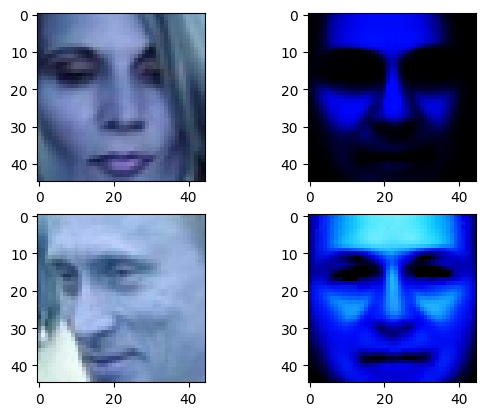

10/10 [==============================] - 1s 77ms/step - loss: 4034.1348
Epoch 92/100
10/10 [==============================] - 0s 31ms/step - loss: 4034.5453
Epoch 93/100
10/10 [==============================] - ETA: 0s - loss: 4034.7526

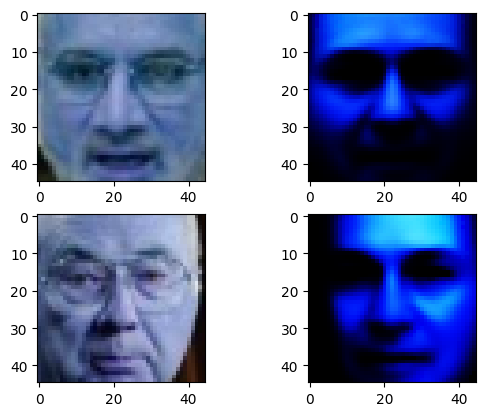

10/10 [==============================] - 1s 75ms/step - loss: 4034.8751
Epoch 94/100
10/10 [==============================] - 0s 28ms/step - loss: 4034.1410
Epoch 95/100
 9/10 [==========================>...] - ETA: 0s - loss: 4034.9913

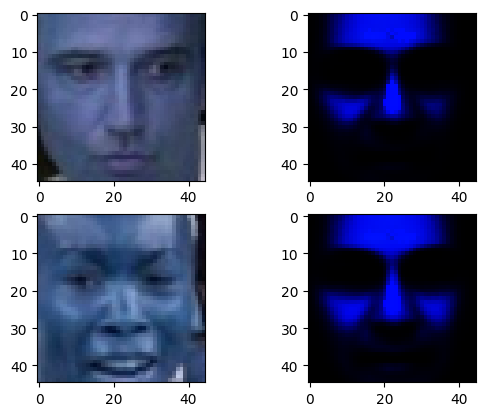

10/10 [==============================] - 1s 77ms/step - loss: 4034.6391
Epoch 96/100
10/10 [==============================] - 0s 30ms/step - loss: 4035.3763
Epoch 97/100
 9/10 [==========================>...] - ETA: 0s - loss: 4036.0512

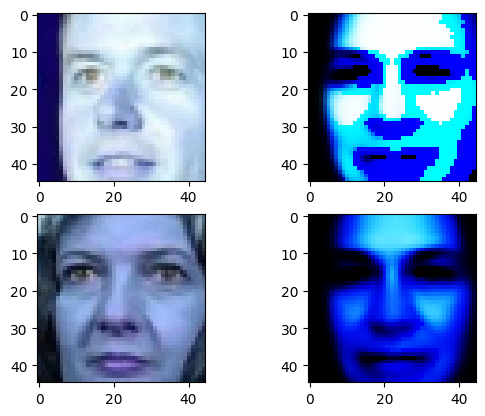

10/10 [==============================] - 1s 82ms/step - loss: 4034.5707
Epoch 98/100
10/10 [==============================] - 0s 29ms/step - loss: 4034.0099
Epoch 99/100
 9/10 [==========================>...] - ETA: 0s - loss: 4034.5861

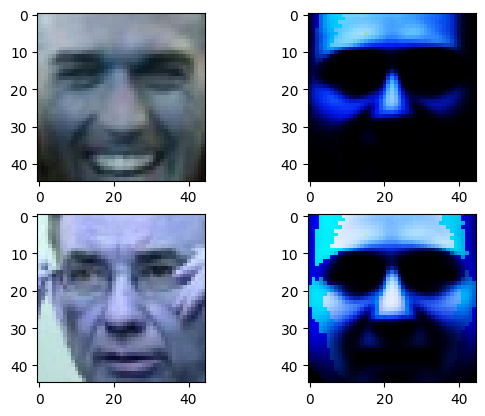

10/10 [==============================] - 1s 77ms/step - loss: 4032.8103
Epoch 100/100
10/10 [==============================] - 0s 27ms/step - loss: 4034.6532


In [332]:
history = vae.fit(X_train,val,epochs=100, batch_size=1024,callbacks=[callback])

Plot the learning curves

In [256]:
X_train.shape

(10000, 6075)

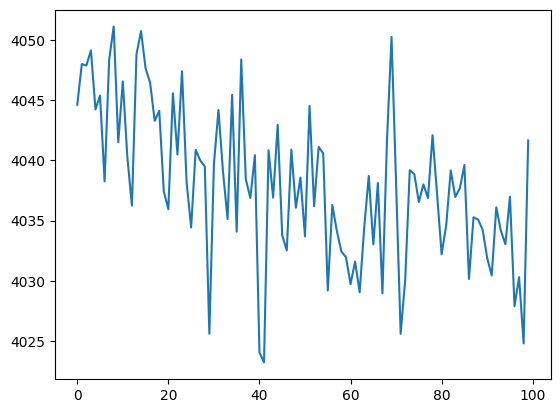

In [333]:
plt.plot(np.arange(100), history.history['loss'])

In [103]:
history.history['loss']

[8.901874542236328,
 8.428140640258789,
 8.7820463180542,
 9.032465934753418,
 8.912059783935547,
 9.285909652709961,
 8.921696662902832,
 9.057804107666016,
 8.820404052734375,
 9.050063133239746,
 8.718453407287598,
 8.490662574768066,
 8.8613862991333,
 8.925926208496094,
 9.275065422058105,
 9.095220565795898,
 9.236995697021484,
 8.763498306274414,
 8.694829940795898,
 8.81197452545166,
 9.315301895141602,
 8.940075874328613,
 8.420492172241211,
 8.711559295654297,
 8.659162521362305,
 8.585858345031738,
 8.657893180847168,
 8.53094482421875,
 9.587240219116211,
 8.744146347045898]

And finally sample from VAE.

In [ ]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it.

# Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE.

<img src="linear.png" alt="linear">

In [ ]:
# your code here

Vanila autoencoders are not suitable for this task